# Assignment 3 by: Jordan Pang (s3902159)


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

# Task 1: kNN-based Collaborative Filtering


In [40]:
# define columns for ratings.dat
ratings_columns = ["UserID", "MovieID", "Rating", "Timestamp"]
# import ratings.dat as df
ratings_df = pd.read_csv("ml-1m/ratings.dat", sep="::", names=ratings_columns, engine="python")
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [41]:
# define columns for movies.dat
movies_columns = ["MovieID", "Title", "Genres"]
# import movies.dat as df
movies_df = pd.read_csv("ml-1m/movies.dat", sep="::", names=movies_columns, engine="python", encoding="ISO-8859-1")
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [42]:
# get number of unique users and movies
n_users = ratings_df.UserID.unique().shape[0]
n_movies = movies_df.MovieID.unique().shape[0]
print(f"{n_users} users")
print(f"{n_movies} movies")

6040 users
3883 movies


In [43]:
# create user_ratings matrix, loop is too slow
ratings_matrix = ratings_df.pivot_table(
    index='UserID',
    columns='MovieID',
    values='Rating',
    fill_value=0  
)

In [44]:
random.seed(42)

# choose random user as test
random_user_id = random.choice(ratings_df.UserID.unique())
print(f"Test User ID: {random_user_id}")

# get random_user_ratings
test_user_ratings = ratings_matrix.loc[random_user_id]

# create training set
train_ratings = ratings_matrix.drop(index=random_user_id)

# convert to numpy matrix
train_matrix = train_ratings.to_numpy()
test_user_matrix = test_user_ratings.to_numpy()

Test User ID: 5239


In [45]:
# fill missing values with 0 for cosine similarity
test_user_filled = test_user_matrix.reshape(1, -1)
train_ratings_filled = train_ratings.fillna(0).to_numpy()

cosine_similarities = cosine_similarity(train_ratings_filled, test_user_filled).flatten()

In [46]:
def compute_pearson(row, target):
    valid = ~np.isnan(row) & ~np.isnan(target)
    if np.sum(valid) == 0:
        return 0
    return np.corrcoef(row[valid], target[valid])[0, 1]

pearson_similarities = train_ratings.apply(lambda row: compute_pearson(row, test_user_ratings), axis=1).fillna(0).to_numpy()

# predicts the target user's ratings for all movies 
def predict_ratings(similarities, train_matrix, k):
    # Get the indices of the top k similar users
    top_k_indices = similarities.argsort()[-k:][::-1]  # Descending order

    # Get the top k similarities
    top_k_similarities = similarities[top_k_indices]

    # Get the ratings of the top k users
    top_k_ratings = train_matrix[top_k_indices]

    # Compute the weighted sum of ratings
    weighted_sum = np.dot(top_k_similarities, top_k_ratings)

    # Compute the sum of similarities
    sum_similarities = np.abs(top_k_similarities).sum()

    # Avoid division by zero
    if sum_similarities == 0:
        sum_similarities = 1e-9

    # Predict the ratings
    predicted_ratings = weighted_sum / sum_similarities
    return predicted_ratings


def calculate_rmse(actual, predicted):
    # Only consider the movies that the test user has rated
    mask = ~np.isnan(actual)
    y_true = actual[mask]
    y_pred = predicted[mask]
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [47]:
k_values = [5, 10, 20, 30, 50]

# Initialize a list to store the results
results = []

# Iterate over each k value
for k in k_values:
    # --- Cosine Similarity Predictions ---
    predicted_cosine = predict_ratings(cosine_similarities, train_matrix, k)
    rmse_cosine = calculate_rmse(test_user_matrix, predicted_cosine)

    # --- Pearson Correlation Predictions ---
    predicted_pearson = predict_ratings(pearson_similarities, train_matrix, k)
    rmse_pearson = calculate_rmse(test_user_matrix, predicted_pearson)

    # --- Append the Results ---
    results.append({
        'k': k,
        'Similarity Metric': 'Cosine',
        'RMSE': rmse_cosine
    })
    results.append({
        'k': k,
        'Similarity Metric': 'Pearson',
        'RMSE': rmse_pearson
    })

# --- 8. Convert Results to DataFrame and Display ---
results_df = pd.DataFrame(results)
print("\nEvaluation Results:")
print(results_df)


Evaluation Results:
    k Similarity Metric      RMSE
0   5            Cosine  1.206242
1   5           Pearson  1.011460
2  10            Cosine  1.088380
3  10           Pearson  0.911975
4  20            Cosine  1.002158
5  20           Pearson  0.896037
6  30            Cosine  0.959728
7  30           Pearson  0.882598
8  50            Cosine  0.951865
9  50           Pearson  0.883839



Optimal k: 30
Best Similarity Metric: Pearson
Lowest RMSE: 0.8826


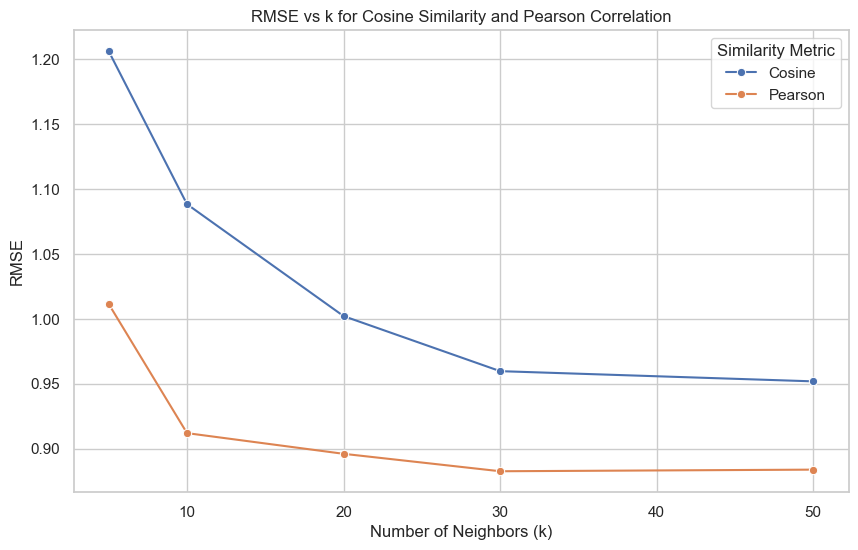

In [48]:
optimal_row = results_df.loc[results_df['RMSE'].idxmin()]
optimal_k = optimal_row['k']
optimal_metric = optimal_row['Similarity Metric']
optimal_rmse = optimal_row['RMSE']

print(f"\nOptimal k: {optimal_k}")
print(f"Best Similarity Metric: {optimal_metric}")
print(f"Lowest RMSE: {optimal_rmse:.4f}")

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='k', y='RMSE', hue='Similarity Metric', marker='o')
plt.title('RMSE vs k for Cosine Similarity and Pearson Correlation')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE')
plt.legend(title='Similarity Metric')
plt.show()

# Task 2: Matrix Factorization-based Recommendation

# Task 3: Ranking-based Evaluation and Comparison